In [1]:
import time
import pickle
import numpy as np
import networkx as nx
import queue
import matplotlib.pyplot as plt

from networkx.algorithms.community.kernighan_lin import kernighan_lin_bisection
import itertools
from scipy.optimize import minimize

from cutqc.main import CutQC
from qiskit import *
from qiskit.circuit import Qubit
from qiskit.circuit.library.standard_gates import XGate
from qiskit.circuit import ControlledGate
from qiskit.quantum_info import Operator, Statevector
from qiskit.visualization import plot_histogram
from qiskit.transpiler.passes import Unroller
from qiskit.transpiler import PassManager

import qsplit_circuit_cutter as qcc
import qsplit_mlrecon_methods as qmm

import cutDQVA as dqva

In [2]:
def get_cut_solution(cutqc, max_subcirc_qubit):
    circname = list(cutqc.circuits.keys())[0]
    subcirc_file = 'cutqc_data/' + circname + '/cc_{}/subcircuits.pckl'.format(max_subcirc_qubit)
    picklefile = open(subcirc_file, 'rb')
    cut_solution = pickle.load(picklefile)
    return cut_solution

def cut_and_print(circ, max_subcircuit_qubit, num_subcircuits, max_cuts):
    circuits = {'my_circ':circ}
    cutqc = CutQC(circuits=circuits, max_subcircuit_qubit=max_subcircuit_qubit,
                  num_subcircuits=num_subcircuits, max_cuts=max_cuts, verbose=1)
    cutsoln = get_cut_solution(cutqc, max_subcircuit_qubit)
    print('Complete Path Map:')
    
    wpm = {}
    for key in cutsoln['complete_path_map']:
        print(key, '->', cutsoln['complete_path_map'][key])
        temp = []
        for frag_qubit in cutsoln['complete_path_map'][key]:
            temp.append((frag_qubit['subcircuit_idx'], frag_qubit['subcircuit_qubit']))
        wpm[key] = tuple(temp)
        
    print('positions:', cutsoln['positions'])
    for i, sc in enumerate(cutsoln['subcircuits']):
        print('Subcirc', i)
        print('\tqubits = {}, gate counts = {}'.format(len(sc.qubits), sc.count_ops()))
        print(sc.draw(fold=200))
    
    return cutsoln['subcircuits'], wpm

In [3]:
def fidelity(dist, actual_dist):
    fidelity = sum( np.sqrt(actual_dist[bits] * dist[bits], dtype = complex)
                    for bits in all_bits
                    if actual_dist.get(bits) and dist.get(bits) )**2
    return fidelity.real if fidelity.imag == 0 else fidelity

def naive_fix(dist):
    norm = sum( value for value in dist.values() if value >= 0 )
    return { bits : value / norm for bits, value in dist.items() if value >= 0 }

## Start with a simple example
The goal is to convert the cutQC `complete_path_map` to the QSPLIT `wire_path_map`

In [4]:
nq = 3
ghz_circ = QuantumCircuit(nq, name='q')
for i in range(nq):
    ghz_circ.rz(i, i)
ghz_circ.h(0)
for i in range(nq-1):
    ghz_circ.cx(i, i+1)
for i in range(nq):
    ghz_circ.rz(i, i)
ghz_circ.draw(fold=-1)

┌───────┐┌───┐     ┌───────┐         
q_0: ┤ RZ(0) ├┤ H ├──■──┤ RZ(0) ├─────────
     ├───────┤└───┘┌─┴─┐└───────┘┌───────┐
q_1: ┤ RZ(1) ├─────┤ X ├────■────┤ RZ(1) ├
     ├───────┤     └───┘  ┌─┴─┐  ├───────┤
q_2: ┤ RZ(2) ├────────────┤ X ├──┤ RZ(2) ├
     └───────┘            └───┘  └───────┘

In [5]:
subcircs, wpm = cut_and_print(ghz_circ, 2, [2], 1)

-------------------- Cut --------------------
Using license file /Users/teague/gurobi.lic
Academic license - for non-commercial use only
my_circ : 1 cuts --> {0: {'effective': 1, 'rho': 0, 'O': 1, 'd': 2}, 1: {'effective': 2, 'rho': 1, 'O': 0, 'd': 2}}
Complete Path Map:
Qubit(QuantumRegister(3, 'q'), 0) -> [{'subcircuit_idx': 0, 'subcircuit_qubit': Qubit(QuantumRegister(2, 'q'), 0)}]
Qubit(QuantumRegister(3, 'q'), 1) -> [{'subcircuit_idx': 0, 'subcircuit_qubit': Qubit(QuantumRegister(2, 'q'), 1)}, {'subcircuit_idx': 1, 'subcircuit_qubit': Qubit(QuantumRegister(2, 'q'), 0)}]
Qubit(QuantumRegister(3, 'q'), 2) -> [{'subcircuit_idx': 1, 'subcircuit_qubit': Qubit(QuantumRegister(2, 'q'), 1)}]
positions: [(Qubit(QuantumRegister(3, 'q'), 1), 1)]
Subcirc 0
	qubits = 2, gate counts = OrderedDict([('rz', 3), ('h', 1), ('cx', 1)])
     ┌───────┐┌───┐     ┌───────┐
q_0: ┤ RZ(0) ├┤ H ├──■──┤ RZ(0) ├
     ├───────┤└───┘┌─┴─┐└───────┘
q_1: ┤ RZ(1) ├─────┤ X ├─────────
     └───────┘     └───┘       

In [6]:
print(subcircs)

[<qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x7f97cc0f2690>, <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x7f97cc0f2410>]


In [7]:
print(wpm)

{Qubit(QuantumRegister(3, 'q'), 0): ((0, Qubit(QuantumRegister(2, 'q'), 0)),), Qubit(QuantumRegister(3, 'q'), 1): ((0, Qubit(QuantumRegister(2, 'q'), 1)), (1, Qubit(QuantumRegister(2, 'q'), 0))), Qubit(QuantumRegister(3, 'q'), 2): ((1, Qubit(QuantumRegister(2, 'q'), 1)),)}


In [8]:
shots = 999999
total_variants = 7
simulation_backend = 'qasm_simulator'
frag_data = qmm.collect_fragment_data(subcircs, wpm, shots=shots // total_variants,
                                      tomography_backend=simulation_backend)
direct_models = qmm.direct_fragment_model(frag_data)
likely_models = qmm.maximum_likelihood_model(direct_models)

direct_recombined_dist = qmm.recombine_fragment_models(direct_models, wpm)
likely_recombined_dist = qmm.recombine_fragment_models(likely_models, wpm)

/Users/teague/anaconda3/envs/cutEnv/lib/python3.7/site-packages/qiskit/ignis/verification/tomography/basis/sicbasis.py:48: DeprecationWarning: The QuantumCircuit.u3 method is deprecated as of 0.16.0. It will be removed no earlier than 3 months after the release date. You should use QuantumCircuit.u instead, which acts identically. Alternatively, you can decompose u3 in terms of QuantumCircuit.p and QuantumCircuit.sx: u3(ϴ,φ,λ) = p(φ+π) sx p(ϴ+π) sx p(λ) (2 pulses on hardware).
  circ.u3(theta, np.pi, 0.0, qubit)


In [9]:
direct_recombined_dist = naive_fix(direct_recombined_dist)

In [10]:
all_bits = [ "".join(bits) for bits in itertools.product(["0", "1"], repeat = nq) ]

actual_state = qmm.get_statevector(ghz_circ)
actual_dist = { "".join(bits) : abs(amp)**2 for bits, amp in zip(all_bits, actual_state) if amp != 0 }

In [11]:
direct_fidelity = fidelity(direct_recombined_dist, actual_dist)
likely_fidelity = fidelity(likely_recombined_dist, actual_dist)

In [12]:
print("actual probability distribution:")
for bits in all_bits:
    try: print(bits, actual_dist[bits])
    except : None

print()
print("'direct' recombined probability distribution:")
for bits in all_bits:
    try: print(bits, direct_recombined_dist[bits])
    except : None

print()
print("'likely' recombined probability distribution:")
for bits in all_bits:
    try: print(bits, likely_recombined_dist[bits])
    except : None

print()
print("'direct' distribution fidelity:", direct_fidelity)
print("'likely' distribution fidelity:", likely_fidelity)

actual probability distribution:
000 0.5000000000000001
111 0.4999999999999999

'direct' recombined probability distribution:
000 0.499737253082761
001 0.00039776518837233846
110 0.001209497863989891
111 0.4986554838648769

'likely' recombined probability distribution:
000 0.49932793416339805
001 0.0016187972455698806
110 0.0008044614044321837
111 0.4982488071866001

'direct' distribution fidelity: 0.9983924439204199
'likely' distribution fidelity: 0.9975764495139606


### NOTE:
The QSPLIT-MLFT adds a small amount of noise to the circuit execution. This can be accounted for within the DQVA algorithm by postprocessing the 
resulting bitstrings and checking that they are valid MIS

## Cut, evalutate, and reconstruct a DQV Ansatz

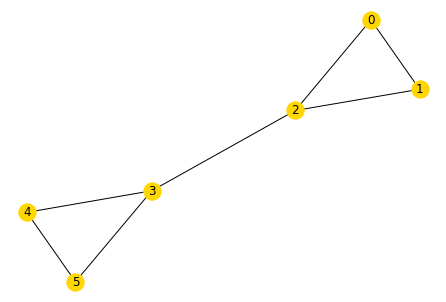

In [13]:
G = nx.Graph()
G.add_edges_from([(0, 1), (0, 2), (1, 2), (2, 3), (3, 4), (3, 5), (4,5)])
nx.draw_spring(G, with_labels=True, node_color='gold')
nq = len(G.nodes())

In [14]:
kl_bisection = ({3, 4, 5}, {0, 1, 2})
params = list(range(1, 2*nq+1+1))
print(params)
cur_init_state = '0'*nq
cur_permutation = list(range(nq))
dqv_circ = dqva.gen_dqva(G, kl_bisection, params=params, init_state=cur_init_state, cut=True,
                         mixer_order=cur_permutation, verbose=1, decompose_toffoli=2,
                         barriers=0, hot_nodes=[2])
print(dqv_circ.count_ops())
dqv_circ.draw(fold=-1)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
Current partition: ({3, 4, 5}, {0, 1, 2})
subgraphs: [[3, 4, 5], [0, 1, 2]]
cutedges: [(2, 3)]
hot nodes: [2]
Qubit 3 is cold! Apply Identity mixer
qubit: 4 num_qubits = 8 neighbors: [3, 5]
qubit: 5 num_qubits = 8 neighbors: [3, 4]
qubit: 0 num_qubits = 8 neighbors: [1, 2]
qubit: 1 num_qubits = 8 neighbors: [0, 2]
qubit: 2 num_qubits = 8 neighbors: [0, 1, 3]
Qubit 3 is cold! Apply Identity mixer
qubit: 4 num_qubits = 8 neighbors: [3, 5]
qubit: 5 num_qubits = 8 neighbors: [3, 4]
qubit: 0 num_qubits = 8 neighbors: [1, 2]
qubit: 1 num_qubits = 8 neighbors: [0, 2]
qubit: 2 num_qubits = 8 neighbors: [0, 1, 3]
OrderedDict([('cx', 176), ('x', 88), ('u1', 84), ('t', 64), ('tdg', 48), ('h', 40), ('crx', 10), ('rz', 6)])


┌───────┐┌───┐                                                                                                                                                                        ┌───┐          ┌───┐  ┌───┐                                                                            ┌───┐              ┌───┐   ┌───┐                                                                                                             ┌───┐   ┌──────────┐                        ┌───┐    ┌─────────┐                         ┌───┐   ┌──────────┐                        ┌───┐    ┌─────────┐                                    ┌───┐   ┌───┐                                                                                                                                     ┌───┐   ┌──────────┐                        ┌───┐    ┌─────────┐                         ┌───┐   ┌──────────┐                             ┌───┐    ┌─────────┐                              ┌───┐   ┌────────┐                                                                                               ┌────────┐┌───┐                                                                                                                                                                           ┌───┐        ┌───┐    ┌───┐                                                                      ┌───┐      ┌───┐   ┌───┐                                                                                                     ┌───┐   ┌──────────┐                        ┌───┐    ┌─────────┐                         ┌───┐   ┌──────────┐                        ┌───┐    ┌─────────┐                                    ┌───┐   ┌───┐                                                                                                                                 ┌───┐   ┌──────────┐                        ┌───┐    ┌─────────┐                         ┌───┐   ┌──────────┐                        ┌───┐    ┌─────────┐                         ┌───┐        
  q_0: ───────────────────────────────────────────────────────────────────────────────────────────┤ RX(2) ├┤ X ├─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────■───────────────────────────────────■──────■───────┤ T ├─────■────┤ X ├──┤ X ├───────────────────────────────■───────────────────────────────────■────■───┤ T ├─────■────────┤ X ├───┤ X ├─────────────────────────────────────────────────────────────────────────────────────────────────────────────┤ X ├───┤ U1(-π/8) ├──■───────────────■─────┤ X ├────┤ U1(π/8) ├──■────────────────■─────┤ X ├───┤ U1(-π/8) ├──■───────────────■─────┤ X ├────┤ U1(π/8) ├──■───────────────────────────■─────┤ X ├───┤ X ├─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤ X ├───┤ U1(-π/8) ├──■───────────────■─────┤ X ├────┤ U1(π/8) ├──■────────────────■─────┤ X ├───┤ U1(-π/8) ├──■────────────────────■─────┤ X ├────┤ U1(π/8) ├──■─────────────────────■─────┤ X ├───┤ RZ(14) ├───────────────────────────────────────────────────────────────────────────────────────────────┤ RX(16) ├┤ X ├────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────■─────────────────────────────────■────■───┤ T ├───■────┤ X ├────┤ X ├──────────────────────────────■──────────────────────────────■────■───┤ T ├───■──┤ X ├───┤ X ├─────────────────────────────────────────────────────────────────────────────────────────────────────┤ X ├───┤ U1(-π/8) ├──■───────────────■─────┤ X ├────┤ U1(π/8) ├──■────────────────■─────┤ X ├───┤ U1(-π/8) ├──■───────────────■─────┤ X ├────┤ U1(π/8) ├──■───────────────────────────■─────┤ X ├───┤ X ├─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤ X ├───┤ U1(-π/8) ├──■───────────────■─────┤ X ├────┤ U1(π/8) ├──■────────────────■─────┤ X ├───┤ U1(-π/8) 

In [15]:
subcircs, wpm = cut_and_print(dqv_circ, nq, [2], 3)

-------------------- Cut --------------------
Using license file /Users/teague/gurobi.lic
Academic license - for non-commercial use only
my_circ : 3 cuts --> {0: {'effective': 3, 'rho': 1, 'O': 2, 'd': 5}, 1: {'effective': 5, 'rho': 2, 'O': 1, 'd': 6}}
Complete Path Map:
Qubit(QuantumRegister(6, 'q'), 0) -> [{'subcircuit_idx': 1, 'subcircuit_qubit': Qubit(QuantumRegister(6, 'q'), 0)}]
Qubit(QuantumRegister(6, 'q'), 1) -> [{'subcircuit_idx': 1, 'subcircuit_qubit': Qubit(QuantumRegister(6, 'q'), 1)}]
Qubit(QuantumRegister(6, 'q'), 2) -> [{'subcircuit_idx': 1, 'subcircuit_qubit': Qubit(QuantumRegister(6, 'q'), 2)}]
Qubit(QuantumRegister(6, 'q'), 3) -> [{'subcircuit_idx': 0, 'subcircuit_qubit': Qubit(QuantumRegister(5, 'q'), 0)}, {'subcircuit_idx': 1, 'subcircuit_qubit': Qubit(QuantumRegister(6, 'q'), 3)}, {'subcircuit_idx': 0, 'subcircuit_qubit': Qubit(QuantumRegister(5, 'q'), 1)}, {'subcircuit_idx': 1, 'subcircuit_qubit': Qubit(QuantumRegister(6, 'q'), 4)}]
Qubit(QuantumRegister(6, 'q'),

In [16]:
shots = 999999
total_variants = 7
simulation_backend = 'qasm_simulator'
frag_data = qmm.collect_fragment_data(subcircs, wpm, shots=15000, tomography_backend=simulation_backend)
direct_models = qmm.direct_fragment_model(frag_data)
likely_models = qmm.maximum_likelihood_model(direct_models)

direct_recombined_dist = qmm.recombine_fragment_models(direct_models, wpm)
likely_recombined_dist = qmm.recombine_fragment_models(likely_models, wpm)

In [17]:
direct_recombined_dist = naive_fix(direct_recombined_dist)

In [18]:
all_bits = [ "".join(bits) for bits in itertools.product(["0", "1"], repeat = len(dqv_circ.qubits)) ]

actual_state = qmm.get_statevector(dqv_circ)
actual_dist = { "".join(bits) : abs(amp)**2 for bits, amp in zip(all_bits, actual_state) if amp != 0 }

In [19]:
direct_fidelity = fidelity(direct_recombined_dist, actual_dist)
likely_fidelity = fidelity(likely_recombined_dist, actual_dist)

In [20]:
print("actual probability distribution:")
for bits in all_bits:
    try: print(bits, actual_dist[bits])
    except : None

print()
print("'direct' recombined probability distribution:")
for bits in all_bits:
    try: print(bits, direct_recombined_dist[bits])
    except : None

print()
print("'likely' recombined probability distribution:")
for bits in all_bits:
    try: print(bits, likely_recombined_dist[bits])
    except : None

print()
print("'direct' distribution fidelity:", direct_fidelity)
print("'likely' distribution fidelity:", likely_fidelity)

actual probability distribution:
00000000 0.04921153618961752
00000001 0.01160385680870136
00000010 0.12992585142939095
00000011 1.168382263079011e-34
00000100 0.01604245166526137
00000101 3.4681576360945495e-35
00000110 5.627012390416527e-36
00000111 3.0258419576275745e-65
00010000 0.16861041945780764
00010001 0.039757571401647464
00010010 0.4451568474414799
00010011 5.513958829485576e-36
00010100 0.05496525233410613
00010101 9.756812489799399e-35
00010110 3.3581398422026406e-35
00010111 6.2375250711182815e-65
00100000 0.02016361632673593
00100001 0.004754489185208567
00100010 0.053234977446191656
00100011 2.061886934593207e-35
00100100 0.006573130313838513
00100101 3.291630664558381e-36
00100110 4.972510388444487e-36
00100111 3.235833100153426e-67
00110000 8.493149646245688e-34
00110001 8.64943643553755e-34
00110010 1.558008812000475e-33
00110011 3.088881222942004e-66
00110100 8.273030927437986e-34
00110101 1.587896688666005e-36
00110110 2.5914910404170474e-36
00110111 1.985210605926

## Incorportate circuit cutting within the DQVA algorithm

In [20]:
def sim_with_cutting(circ, backend, sim, shots, G, verbose, mode='direct'):
    circuits = {'my_circ':circ}
    max_subcircuit_qubit = 6
    num_subcircuits = [2]
    max_cuts = 4
    cutqc = CutQC(circuits=circuits, max_subcircuit_qubit=max_subcircuit_qubit,
                  num_subcircuits=num_subcircuits, max_cuts=max_cuts, verbose=verbose)
    
    # TODO: modify cutQC to return the cutcoln instead of using pickle
    #cutsoln = get_cut_solution(cutqc, max_subcircuit_qubit)
    cutsoln = cutqc.cut_solns[0]
    print('Split circuit into {} subcircuits with {} qubits'.format(len(cutsoln['subcircuits']),
                                                                    [len(circ.qubits) for circ in cutsoln['subcircuits']]))
    
    wpm = {}
    for key in cutsoln['complete_path_map']:
        temp = []
        for frag_qubit in cutsoln['complete_path_map'][key]:
            temp.append((frag_qubit['subcircuit_idx'], frag_qubit['subcircuit_qubit']))
        wpm[key] = tuple(temp)
        
    shots = 999999
    total_variants = 7
    simulation_backend = 'qasm_simulator'
    frag_data = qmm.collect_fragment_data(cutsoln['subcircuits'], wpm, shots=15000, tomography_backend=simulation_backend)
    
    direct_models = qmm.direct_fragment_model(frag_data)
    if mode is 'direct':
        direct_recombined_dist = qmm.recombine_fragment_models(direct_models, wpm)
        dirty_probs = dqva.strip_ancillas(naive_fix(direct_recombined_dist), circ)
    elif mode is 'likely':
        likely_models = qmm.maximum_likelihood_model(direct_models)
        dirty_probs = dqva.strip_ancillas(qmm.recombine_fragment_models(likely_models, wpm), circ)
    else:
        raise Exception('Unknown recombination mode:', mode)
        
    clean_probs = {}
    for bitstr, probability in dirty_probs.items():
        if dqva.is_indset(bitstr, G):
            clean_probs[bitstr] = probability
    
    factor = 1.0 / sum(clean_probs.values())
    probs = {k: v*factor for k, v in clean_probs.items() }
    
    return probs

In [14]:
def cut_dqva(init_state, G, m=4, threshold=1e-5, cutoff=5, sim='statevector', shots=8192, verbose=0):

    kl_bisection = kernighan_lin_bisection(G)
    print('kl bisection:', kl_bisection)
    backend = Aer.get_backend(sim+'_simulator')
    cur_permutation = list(np.random.permutation(list(G.nodes)))

    history = []

    def f(params):
        # Generate a circuit
        # Circuit cutting is not required here, but the circuit should be generated using
        # as much info about the cutting as possible
        dqv_circ = dqva.gen_dqva(G, kl_bisection, params=params, init_state=cur_init_state, cut=True,
                                 mixer_order=cur_permutation, verbose=verbose, decompose_toffoli=2,
                                 barriers=0, hot_nodes=[2])

        # Compute the cost function
        # Circuit cutting will need to be used to perform the execution
        probs = sim_with_cutting(dqv_circ, backend, sim, shots, G, verbose)

        avg_cost = 0
        for sample in probs.keys():
            x = [int(bit) for bit in list(sample)]
            # Cost function is Hamming weight
            avg_cost += probs[sample] * sum(x)

        # Return the negative of the cost for minimization
        return -avg_cost

    # Step 3: Dynamic Ansatz Update
    # Begin outer optimization loop
    best_indset = init_state
    best_init_state = init_state
    cur_init_state = init_state

    # Randomly permute the order of mixer unitaries m times
    for step4_round in range(1, m+1):
        step3_round = 1
        new_hamming_weight = dqva.hamming_weight(cur_init_state)
        old_hamming_weight = -1

        # Attempt to improve the Hamming weight until no further improvements can be made
        while new_hamming_weight > old_hamming_weight:
            print('Start round {}.{}, Initial state = {}'.format(step4_round, step3_round, cur_init_state))

            # Inner variational loop
            num_params = 2 * (len(cur_init_state) - dqva.hamming_weight(cur_init_state)) + 1
            print('\tNum params =', num_params)
            init_params = np.random.uniform(low=0.0, high=2*np.pi, size=num_params)
            print('\tCurrent Mixer Order:', cur_permutation)
            out = minimize(f, x0=init_params, method='COBYLA')
            opt_params = out['x']
            opt_cost = out['fun']
            #print('\tOptimal Parameters:', opt_params)
            print('\tOptimal cost:', opt_cost)

            # Get the results of the optimized circuit
            dqv_circ = dqva.gen_dqva(G, kl_bisection, params=opt_params, init_state=cur_init_state, cut=True,
                                     mixer_order=cur_permutation, verbose=verbose, decompose_toffoli=2,
                                     barriers=0, hot_nodes=[2])
            
            probs = sim_with_cutting(dqv_circ, backend, sim, shots, G, verbose)

            # Select the top [cutoff] counts
            top_counts = sorted([(key, counts[key]) for key in counts if counts[key] > threshold],
                                key=lambda tup: tup[1], reverse=True)[:cutoff]
            # Check if we have improved the Hamming weight
            old_hamming_weight = hamming_weight(cur_init_state)
            better_strs = []
            for bitstr, prob in top_counts:
                this_hamming = hamming_weight(bitstr)
                if is_indset(bitstr, G) and this_hamming > old_hamming_weight:
                    better_strs.append((bitstr, this_hamming))
            better_strs = sorted(better_strs, key=lambda t: t[1], reverse=True)
            prev_init_state = cur_init_state

            # Save current results to history
            temp_history = {'round':'{}.{}'.format(step4_round, step3_round),
                            'cost':opt_cost, 'permutation':cur_permutation, 'topcounts':top_counts,
                            'previnit':prev_init_state}

            # If no improvement was made, break and go to next step4 round
            if len(better_strs) == 0:
                print('\tNone of the measured bitstrings had higher Hamming weight than:', prev_init_state)
                history.append(temp_history)
                break

            # Otherwise, save the new bitstring and check if it is better than all we have seen thus far
            cur_init_state, new_hamming_weight = better_strs[0]
            if new_hamming_weight > hamming_weight(best_indset):
                best_indset = cur_init_state
                best_init_state = prev_init_state
            print('\tFound new independent set: {}, Hamming weight = {}'.format(cur_init_state, new_hamming_weight))
            temp_history['curinit'] = cur_init_state
            history.append(temp_history)
            step3_round += 1

        # Choose a new permutation of the mixer unitaries that have NOT been set to identity
        identity_mixers = [i for i in range(len(cur_init_state)) if list(reversed(cur_init_state))[i] == '1']
        non_identity_mixers = [i for i in range(len(cur_init_state)) if list(reversed(cur_init_state))[i] == '0']
        permutation = np.random.permutation(non_identity_mixers)
        perm_queue = queue.Queue()
        for p in permutation:
            perm_queue.put(p)
        for i, mixer in enumerate(cur_permutation):
            if mixer in identity_mixers:
                continue
            else:
                cur_permutation[i] = perm_queue.get()

    print('\tRETURNING, best hamming weight:', new_hamming_weight)
    return best_indset, opt_params, best_init_state, kl_bisection, history

[(0, 1), (0, 2), (1, 2), (2, 3), (3, 4), (3, 5), (4, 5)]


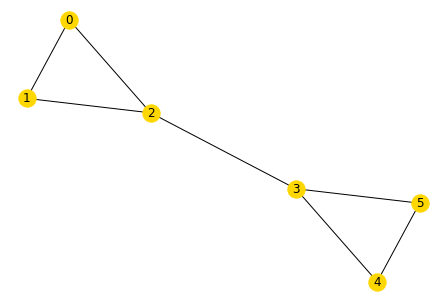

In [7]:
G = dqva.test_graph(3, 0.9)
print(list(G.edges()))
nx.draw_spring(G, with_labels=True, node_color='gold')

In [21]:
cut_dqva('0'*len(G.nodes), G, m=4, threshold=1e-5, cutoff=5, sim='statevector', shots=8192, verbose=0)

kl bisection: ({3, 4, 5}, {0, 1, 2})
Start round 1.1, Initial state = 000000
	Num params = 13
	Current Mixer Order: [0, 1, 5, 2, 4, 3]
Using license file /Users/teague/gurobi.lic
Academic license - for non-commercial use only
Split circuit into 2 subcircuits with [5, 6] qubits
Using license file /Users/teague/gurobi.lic
Academic license - for non-commercial use only
Split circuit into 2 subcircuits with [5, 6] qubits
Using license file /Users/teague/gurobi.lic
Academic license - for non-commercial use only
Split circuit into 2 subcircuits with [5, 6] qubits
Using license file /Users/teague/gurobi.lic
Academic license - for non-commercial use only
Split circuit into 2 subcircuits with [5, 6] qubits
Using license file /Users/teague/gurobi.lic
Academic license - for non-commercial use only
Split circuit into 2 subcircuits with [5, 6] qubits
Using license file /Users/teague/gurobi.lic
Academic license - for non-commercial use only
Split circuit into 2 subcircuits with [5, 6] qubits
Using l

Process ForkPoolWorker-541:
Process ForkPoolWorker-325:
Process ForkPoolWorker-404:
Process ForkPoolWorker-434:
Process ForkPoolWorker-335:
Process ForkPoolWorker-334:
Process ForkPoolWorker-332:
Process ForkPoolWorker-362:
Process ForkPoolWorker-298:
Process ForkPoolWorker-300:


KeyboardInterrupt: 

Process ForkPoolWorker-329:
Process ForkPoolWorker-299:
Process ForkPoolWorker-297:
Process ForkPoolWorker-363:
Process ForkPoolWorker-293:
Process ForkPoolWorker-294:
Process ForkPoolWorker-295:
Process ForkPoolWorker-291:
Process ForkPoolWorker-261:
Process ForkPoolWorker-258:
Process ForkPoolWorker-260:
Process ForkPoolWorker-259:
Process ForkPoolWorker-263:
Process ForkPoolWorker-255:
Process ForkPoolWorker-253:
Process ForkPoolWorker-228:
Process ForkPoolWorker-226:
Process ForkPoolWorker-227:
Process ForkPoolWorker-613:
Process ForkPoolWorker-622:
Process ForkPoolWorker-222:
Process ForkPoolWorker-225:
Process ForkPoolWorker-218:
Process ForkPoolWorker-621:
Process ForkPoolWorker-623:
Process ForkPoolWorker-620:
Process ForkPoolWorker-191:
Process ForkPoolWorker-189:
Process ForkPoolWorker-153:
Process ForkPoolWorker-185:
Process ForkPoolWorker-147:
Process ForkPoolWorker-148:
Process ForkPoolWorker-615:
Process ForkPoolWorker-585:
Process ForkPoolWorker-546:
Process ForkPoolWork